## Notebook to create a regional rainfall-runoff model using an LSTM network for CAMELS CH Dataset

*LSTM Architecture with gru cell implemetation;*
*Only 229 catchments belonging to CH from CAMELS CH*

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. The code allows for the creation of single-basin models, but it is conceptualized to create 
regional models. The code is intended as an intial introduction to the topic, in which we prioritized interpretability
over modularity. The model generated in this code makes use of the CAMELS CH Datset [2]

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

**Authors:**
- Eduardo Acuna Espinoza (eduardo.espinoza@kit.edu)
- Ralf Loritz
- Manuel Álvarez Chaves

**Adaptations:**
- Sanika Baste (sanika.baste@kit.edu)

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

[2]: Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., and Fenicia, F.: CAMELS-CH: hydro-meteorological time series and landscape attributes for 331 catchments in hydrologic Switzerland, Earth Syst. Sci. Data, 15, 5755–5784, https://doi.org/10.5194/essd-15-5755-2023, 2023.

In [1]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append("../aux_functions")
sys.path.append("../datasetzoo")
sys.path.append("../modelzoo")

# Import classes and functions from other files
from functions_training import nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

# Import dataset to use
from camelsch import CAMELS_CH

# Import model
# from customlstm_original_softplus import customLSTM

# ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Part 1. Initialize information

In [2]:
# Define experiment name
experiment_name = "LSTM_CAMELS_CH_gru_229CH"

# paths to access the information
path_entities = "../../data/basin_id/basins_camels_ch_229_onlyCH.txt"
path_data = "../../data/CAMELS_CH"

# dynamic forcings and target
dynamic_input = ['precipitation(mm/d)', 'temperature_min(degC)', 'temperature_max(degC)', 'rel_sun_dur(%)', 'swe(mm)']
target = ['discharge_spec(mm/d)']

# static attributes that will be used
static_input = ['area',
                'elev_mean',
                'slope_mean',
                'sand_perc',
                'silt_perc',
                'clay_perc',
                'porosity',
                'conductivity',
                'glac_area',
                'dwood_perc',
                'ewood_perc',
                'crop_perc',
                'urban_perc',
                'reservoir_cap',
                'p_mean',
                'pet_mean',
                'p_seasonality',
                'frac_snow',
                'high_prec_freq',
                'low_prec_freq',
                'high_prec_dur',
                'low_prec_dur']

# time periods
training_period = ['1995-10-01','2005-09-30']
validation_period = ['2005-10-01','2010-09-30']
testing_period = ['2010-10-01','2015-09-30']

model_hyper_parameters = {
    "input_size_lstm": len(dynamic_input) + len(static_input),
    "no_of_layers":1,  
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size_training":256,
    "batch_size_validation":512,
    "batch_size_testing":(pd.to_datetime(testing_period[1])-pd.to_datetime(testing_period[0])).days+1,
    "no_of_epochs": 30,             
    "drop_out_rate": 0.4, 
    "learning_rate": 0.001,
    "adapt_learning_rate_epoch": 10,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3,
    "validate_every": 1,
    "validate_n_random_basins": -1
    }

# device to train the model
running_device = "gpu" #cpu or gpu

# define random seed
seed = 17

# colorblind friendly palette for plotting
color_palette = {"observed": "#1f78b4","simulated": "#ff7f00"}

In [3]:
# Create folder to store the results
path_save_folder = "../results/"+experiment_name
create_folder(folder_path=path_save_folder)

Folder '../results/LSTM_CAMELS_CH_gru_229CH' already exists.


In [4]:
# check if model will be run in gpu or cpu and define device
if running_device == "gpu":
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == "cpu":
    device = "cpu"

Tesla V100-SXM2-32GB


Part 2. Create dataset and dataloader for training

In [5]:
# Dataset training
training_dataset = CAMELS_CH(dynamic_input= dynamic_input,
                             target= target, 
                             sequence_length= model_hyper_parameters["seq_length"],
                             time_period= training_period,
                             path_data= path_data,
                             path_entities= path_entities,
                             static_input= static_input,
                             check_NaN= True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()

In [6]:
# Dataloader training
train_loader = DataLoader(dataset = training_dataset, 
                          batch_size = model_hyper_parameters["batch_size_training"],
                          shuffle = True,
                          drop_last = True)

print("Batches in training: ", len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample["x_lstm"].shape} | y_obs: {sample["y_obs"].shape} | basin_std: {sample["basin_std"].shape}')

Batches in training:  1382
x_lstm: torch.Size([256, 365, 27]) | y_obs: torch.Size([256, 1, 1]) | basin_std: torch.Size([256, 1, 1])


Part 3. Create dataset for validation

In [7]:
# We will create an individual dataset per basin. This will give us more flexibility
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
validation_dataset = {}

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= validation_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity]= dataset

In [8]:
from typing import Dict, Union
import math
from collections import defaultdict
import torch
import torch.nn as nn
from cudalstm import CudaLSTM

class customLSTM(nn.Module):
    """LSTM cell

    Parameters
    ----------
    hyperparameters : Dict[str, Union[int, float, str, dict]]
        Various hyperparameters of the model

    """
    def __init__(self, hyperparameters: Dict[str, Union[int, float, str, dict]]):

        # Run the __init__ method of CudaLSTM class
        super().__init__()
              
        self._num_layers = hyperparameters['no_of_layers']
        self._hidden_size = hyperparameters['hidden_size']
        self._input_size = hyperparameters['input_size_lstm']
        self._initial_forget_bias = hyperparameters['set_forget_gate']
        self.cell = _GRUCell(input_size = hyperparameters['input_size_lstm'],
                                hidden_size = hyperparameters['hidden_size'],
                                initial_forget_bias = hyperparameters['set_forget_gate'])

        self.dropout = torch.nn.Dropout(hyperparameters['drop_out_rate'])
        self.linear = nn.Linear(in_features = hyperparameters['hidden_size'], out_features=1)
           
    def forward(self, x: torch.Tensor):
        """Forward pass of lstm network 

        Parameters
        ----------
        x_lstm: torch.Tensor
            Tensor of size [batch_size, time_steps, input_size_lstm].

        Returns
        -------
        pred: Dict[str, torch.Tensor]

        """
        
        # initialize hidden state with zeros
        batch_size, seq_len, _ =  x.shape
        h0 = x.data.new(batch_size, self._hidden_size).zero_()

        output = defaultdict(list)
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            cell_output = self.cell(x_t=x_t, h_0=h0)
            h0 = cell_output['h_n']

            for key, cell_out in cell_output.items():
                output[key].append(cell_out)

        # stack to [batch size, sequence length, hidden size]
        pred = {key: torch.stack(val, 1) for key, val in output.items()}

        pred.update({"y_hat": self.linear(self.dropout(pred['h_n'][:,-1, :]))})
        return pred
    
    def copy_weights(self, optimized_lstm: CudaLSTM):
        """Copy weights from a `CudaLSTM` or `EmbCudaLSTM` into this model class

        Parameters
        ----------
        optimized_lstm : Union[CudaLSTM, EmbCudaLSTM]
            Model instance of a `CudaLSTM` (neuralhydrology.modelzoo.cudalstm) or `EmbCudaLSTM`
            (neuralhydrology.modelzoo.embcudalstm).
            
        Raises
        ------
        RuntimeError
            If `optimized_lstm` is an `EmbCudaLSTM` but this model instance was not created with an embedding network.
        """

        # copy lstm cell weights
        self.cell.copy_weights(optimized_lstm.lstm, layer=0)

        # copy weights of linear layer
        self.linear.load_state_dict(optimized_lstm.linear.state_dict())
    
class _GRUCell(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, initial_forget_bias: float = 0.0):
        super(_GRUCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.initial_forget_bias = initial_forget_bias

        self.w_ir = nn.Parameter(torch.FloatTensor(hidden_size, input_size))
        self.w_iz = nn.Parameter(torch.FloatTensor(hidden_size, input_size))
        self.w_in = nn.Parameter(torch.FloatTensor(hidden_size, input_size))
        
        self.w_hr = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size))
        self.w_hz = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size))
        self.w_hn = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size))

        self.b_ir = nn.Parameter(torch.FloatTensor(hidden_size))
        self.b_iz = nn.Parameter(torch.FloatTensor(hidden_size))
        self.b_in = nn.Parameter(torch.FloatTensor(hidden_size))
        
        self.b_hr = nn.Parameter(torch.FloatTensor(hidden_size))
        self.b_hz = nn.Parameter(torch.FloatTensor(hidden_size))
        self.b_hn = nn.Parameter(torch.FloatTensor(hidden_size))
        
        self._reset_parameters()

    def _reset_parameters(self):
        """Special initialization of certain model weights."""
        stdv = math.sqrt(3 / self.hidden_size)
        for weight in self.parameters():
            if len(weight.shape) > 1:
                weight.data.uniform_(-stdv, stdv)
            else:
                nn.init.zeros_(weight)

        # if self.initial_forget_bias != 0:
        #     self.b_hh.data[self.hidden_size:2 * self.hidden_size] = self.initial_forget_bias

    def forward(self, x_t: torch.Tensor, h_0: torch.Tensor) -> Dict[str, torch.Tensor]:
        r_t_ = torch.matmul(x_t, self.w_ir.T) + self.b_ir + torch.matmul(h_0, self.w_hr.T) + self.b_hr
        r_t = torch.sigmoid(r_t_)
        z_t_ = torch.matmul(x_t, self.w_iz.T) + self.b_iz + torch.matmul(h_0, self.w_hz.T) + self.b_hz
        z_t = torch.sigmoid(z_t_)
        n_t_ = (torch.matmul(x_t, self.w_in.T) + self.b_in) + r_t*(torch.matmul(h_0, self.w_hn.T) + self.b_hn)
        n_t = torch.tanh(n_t_)
        h_1 = (1-z_t)*n_t + z_t*h_0

        return {'h_n': h_1, 'n_t_': n_t_, 'z_t_': z_t_, 'r_t_': r_t_}

    def copy_weights(self, cudnnlstm: nn.Module, layer: int):

        assert self.hidden_size == cudnnlstm.hidden_size
        assert self.input_size == cudnnlstm.input_size

        self.w_hh.data = getattr(cudnnlstm, f"weight_hh_l{layer}").data
        self.w_ih.data = getattr(cudnnlstm, f"weight_ih_l{layer}").data
        self.b_hh.data = getattr(cudnnlstm, f"bias_hh_l{layer}").data
        self.b_ih.data = getattr(cudnnlstm, f"bias_ih_l{layer}").data

Part 4. Train LSTM

In [ ]:
# construct model
set_random_seed(seed=seed)
lstm_model = customLSTM(hyperparameters=model_hyper_parameters).to(device)
# training an already trained model further
path_save_folder__ = "../results/LSTM_CAMELS_CH_gru_229CH"
lstm_model.load_state_dict(torch.load(path_save_folder__ + "/epoch_20", map_location=device))

# optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])

# define learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                             step_size=model_hyper_parameters["adapt_learning_rate_epoch"],
#                                             gamma=model_hyper_parameters["adapt_gamma_learning_rate"])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma=0.5)
# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
# lstm_model.cell.b_hh.data[model_hyper_parameters["hidden_size"]:2 * model_hyper_parameters["hidden_size"]]=\
#     model_hyper_parameters["set_forget_gate"]

training_time = time.time()
# Loop through the different epochs
for epoch in range(21, model_hyper_parameters["no_of_epochs"]+1):
    
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    lstm_model.train()
    for sample in train_loader: 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        pred  = lstm_model(sample["x_lstm"].to(device)) # forward call
        
        loss = nse_basin_averaged(y_sim=pred["y_hat"], 
                                  y_obs=sample["y_obs"].to(device), 
                                  per_basin_target_std=sample["basin_std"].to(device))
        
        loss.backward() # backpropagates
        optimizer.step() # update weights
        total_loss.append(loss.item())
        
        # remove from cuda
        del sample["x_lstm"], sample["y_obs"], sample["basin_std"], pred
        torch.cuda.empty_cache()
        
    #training report  
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'
    
    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % model_hyper_parameters["validate_every"] == 0:
        lstm_model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if model_hyper_parameters["validate_n_random_basins"] <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, model_hyper_parameters["validate_n_random_basins"])
            
            # go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(dataset=validation_dataset[basin], 
                                    batch_size=model_hyper_parameters["batch_size_validation"], 
                                    shuffle=False, 
                                    drop_last = False)
                
                df_ts = pd.DataFrame()
                for sample in loader:
                    pred  = lstm_model(sample["x_lstm"].to(device)) 
                    # backtransformed information
                    y_sim = pred["y_hat"]* validation_dataset[basin].scaler["y_std"].to(device) +\
                        validation_dataset[basin].scaler["y_mean"].to(device)

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                       "y_sim": y_sim.flatten().cpu().detach()}, 
                                      index=pd.to_datetime(sample["date"]))

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del pred, y_sim
                    torch.cuda.empty_cache()       
                
                validation_results[basin] = df_ts
                 
            #average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| NSE validation: {"%.3f "% (loss_validation)}'

    
    # save model after every epoch
    path_saved_model = path_save_folder+"/epoch_" + str(epoch)
    torch.save(lstm_model.state_dict(), path_saved_model)
            
    # print epoch report
    report += f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | LR:{"%.5f "% (optimizer.param_groups[0]["lr"])}'
    print(report)
    write_report(file_path=path_save_folder+"/run_progress.txt", text=report)
    # modify learning rate
    scheduler.step()

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(file_path=path_save_folder+"/run_progress.txt", text=report)   

Epoch: 21 | Loss training: 0.011 | NSE validation: 0.832 | Epoch time: 751.8  s | LR:0.00025 
Epoch: 22 | Loss training: 0.011 | NSE validation: 0.829 | Epoch time: 742.6  s | LR:0.00025 
Epoch: 23 | Loss training: 0.011 | NSE validation: 0.834 | Epoch time: 761.7  s | LR:0.00025 
Epoch: 24 | Loss training: 0.011 | NSE validation: 0.831 | Epoch time: 819.2  s | LR:0.00025 
Epoch: 25 | Loss training: 0.011 | NSE validation: 0.827 | Epoch time: 766.8  s | LR:0.00025 
Epoch: 26 | Loss training: 0.011 | NSE validation: 0.831 | Epoch time: 768.3  s | LR:0.00025 
Epoch: 27 | Loss training: 0.011 | NSE validation: 0.832 | Epoch time: 768.2  s | LR:0.00025 


Part 5. Test LSTM

In [9]:
# In case I already trained an LSTM I can re-construct the model
lstm_model = customLSTM(hyperparameters=model_hyper_parameters).to(device)
lstm_model.load_state_dict(torch.load(path_save_folder + "/epoch_27", map_location=device))

<All keys matched successfully>

In [62]:
# We will create an individual dataset per basin. This will give us more flexibility
#path_entities = "../../data/basin_id/basins_camels_gb_lees.txt"
# entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
entities_ids = ['2346', '2303', '2494']
testing_dataset = {}
seq_length = model_hyper_parameters["seq_length"]-1
idx_to_change = [512, 519]

# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= testing_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    
    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    dataset.sequence_data[entity]['x_d'][idx_to_change[0]+seq_length:idx_to_change[1]+seq_length, 0] = 200
    # dataset.sequence_data[entity]['x_s'][:] = 0
    testing_dataset[entity]= dataset

In [63]:
lstm_model.eval()
inspect_results_states = {}
inspect_results = {}
create_folder(folder_path=path_save_folder+"/inspect_results_states")

with torch.no_grad():
    for basin, dataset in testing_dataset.items():
        loader = DataLoader(dataset = dataset, 
                            batch_size = model_hyper_parameters["batch_size_testing"], 
                            shuffle = False, 
                            drop_last = False) 

        df_ts = pd.DataFrame()
        inspectmodel_output = []

        for sample in loader:
            pred  = lstm_model(sample["x_lstm"].to(device)) 
            # backtransformed information
            y_sim = pred["y_hat"]* dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            _output = {"h_n": pred["h_n"].cpu().detach(), 
                        "n_t_": pred["n_t_"].cpu().detach(),
                        "z_t_":pred["z_t_"].cpu().detach(),
                        "r_t_":pred["r_t_"].cpu().detach(),
                        "y_hat": y_sim.cpu().detach()}

            inspectmodel_output.append(_output)

            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                               "y_hat": pred["y_hat"].flatten().cpu().detach(),
                                "y_sim": y_sim.flatten().cpu().detach()}, 
                                index=pd.to_datetime(sample["date"]))
            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del pred, y_sim
            torch.cuda.empty_cache()       
        
        inspect_results_states[basin] = inspectmodel_output
        inspect_results[basin] = df_ts

        # Save results as a pickle file
        with open(path_save_folder+"/inspect_results_states/"+str(basin)+".pickle", "wb") as f_:
           pickle.dump(inspectmodel_output, f_)
            
        del inspectmodel_output, df_ts
        print('Testing using CustomLSTM complete for ' + str(basin))

# Save results as a pickle file
with open(path_save_folder+"/inspect_results.pickle", "wb") as f:
    pickle.dump(inspect_results, f)

Folder '../results/LSTM_CAMELS_CH_gru_229CH/inspect_results_states' already exists.
Testing using CustomLSTM complete for 2346
Testing using CustomLSTM complete for 2303
Testing using CustomLSTM complete for 2494


Part 6. Initial analysis

In [64]:
# In case we already ran our model
#with open(path_save_folder+"/test_results.pickle", "rb") as f:
#    test_results = pickle.load(f)

In [65]:
# Loss testing
loss_testing = nse(df_results=inspect_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing,3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(path_save_folder+"/NSE.csv", index=True, header=True)

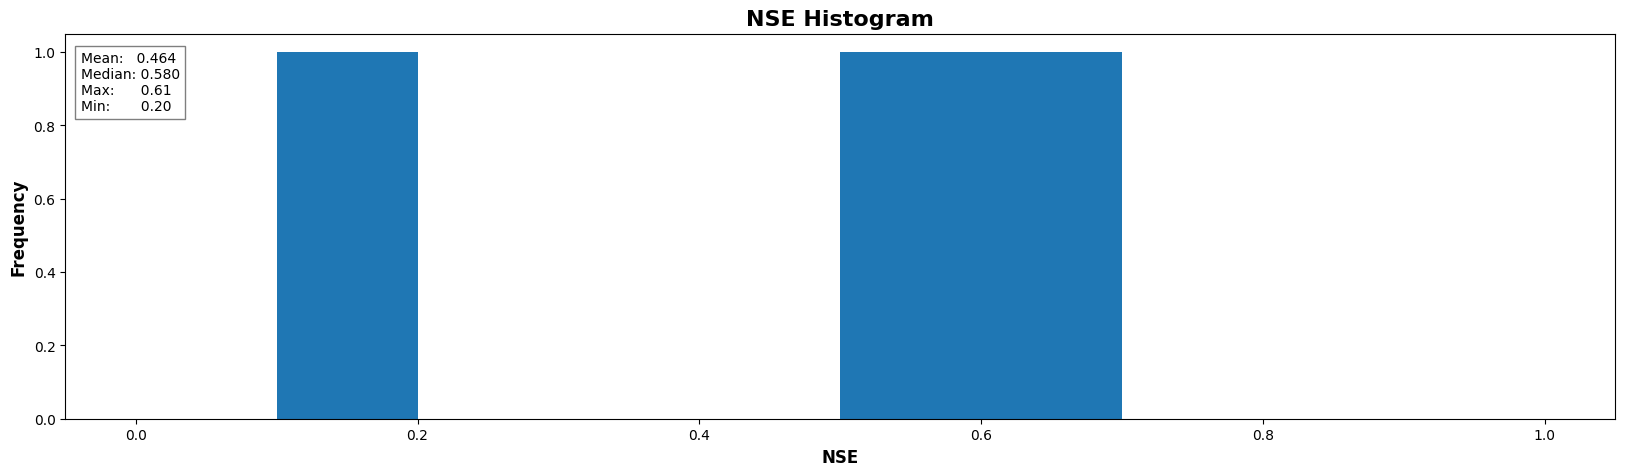

In [66]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.3f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.3f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
#plt.savefig(save_folder+"/NSE_LSTM_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

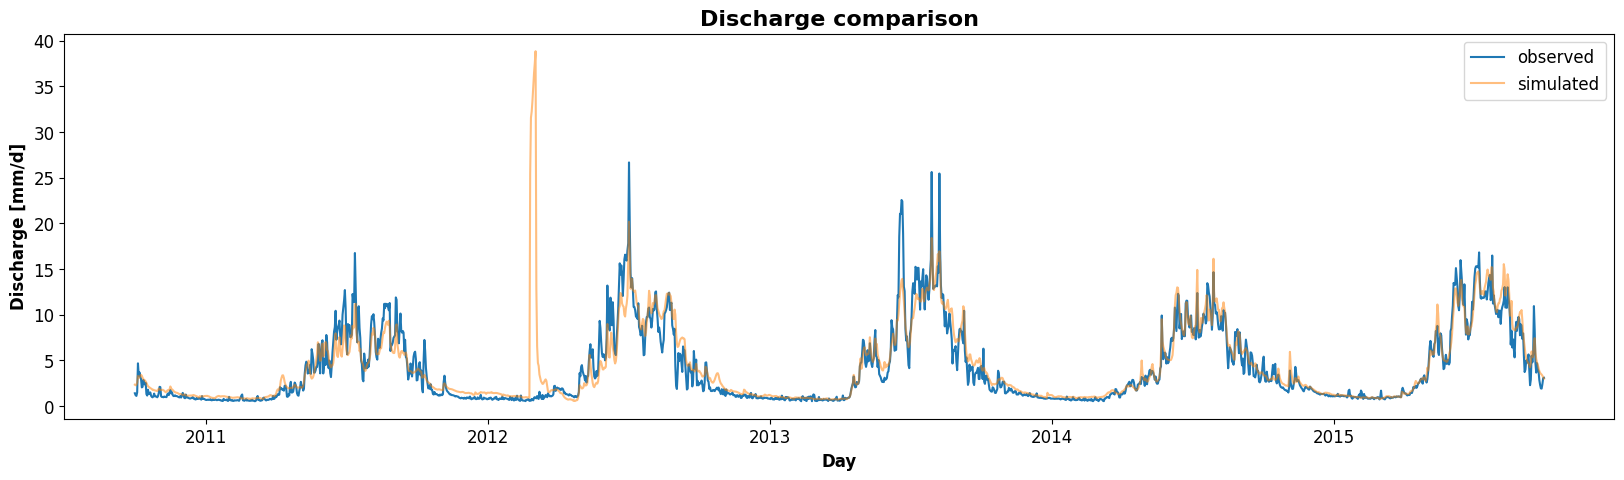

In [67]:
# Plot simulated and observed discharges
basin_to_analyze = "2346"

plt.plot(inspect_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(inspect_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Day", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Discharge comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()
#plt.savefig(save_folder+"/Model_Comparison.png", bbox_inches="tight", pad_inches=0)

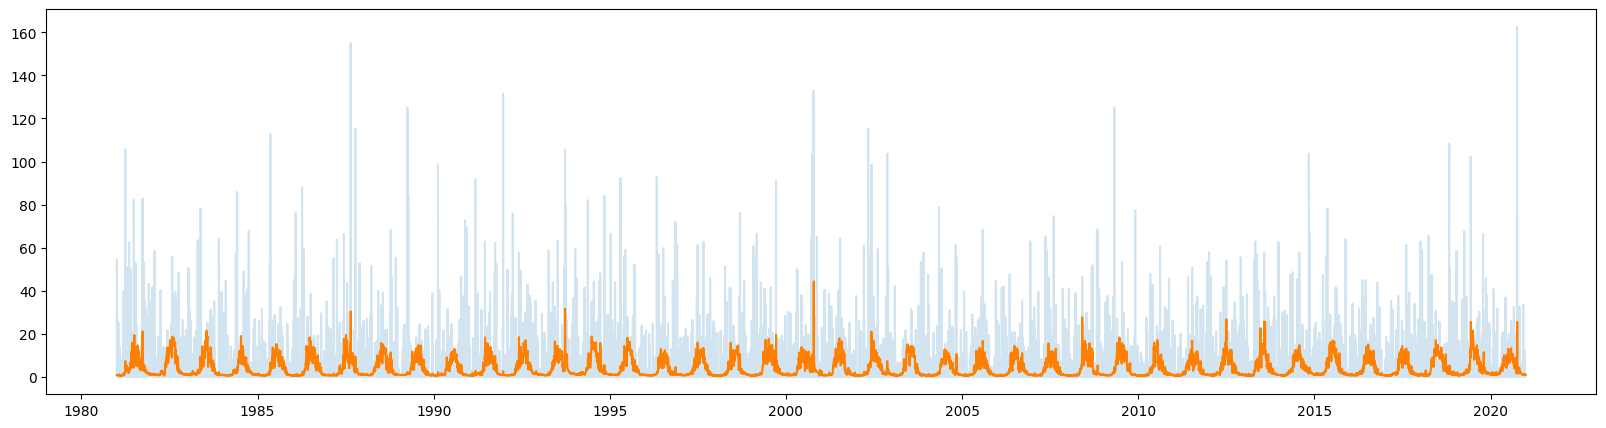

In [68]:
from pathlib import Path
path_timeseries_obs = Path(path_data) / 'timeseries' / 'observation_based' / f'CAMELS_CH_obs_based_{basin_to_analyze}.csv'
# load time series
df_obs = pd.read_csv(path_timeseries_obs)
df_obs = df_obs.set_index('date')
df_obs.index = pd.to_datetime(df_obs.index, format="%Y-%m-%d")

plt.plot(df_obs["precipitation(mm/d)"], label="precipitation", alpha=0.2, color=color_palette["observed"])
plt.plot(df_obs["discharge_spec(mm/d)"], label="discharge", color=color_palette["simulated"])
plt.show()

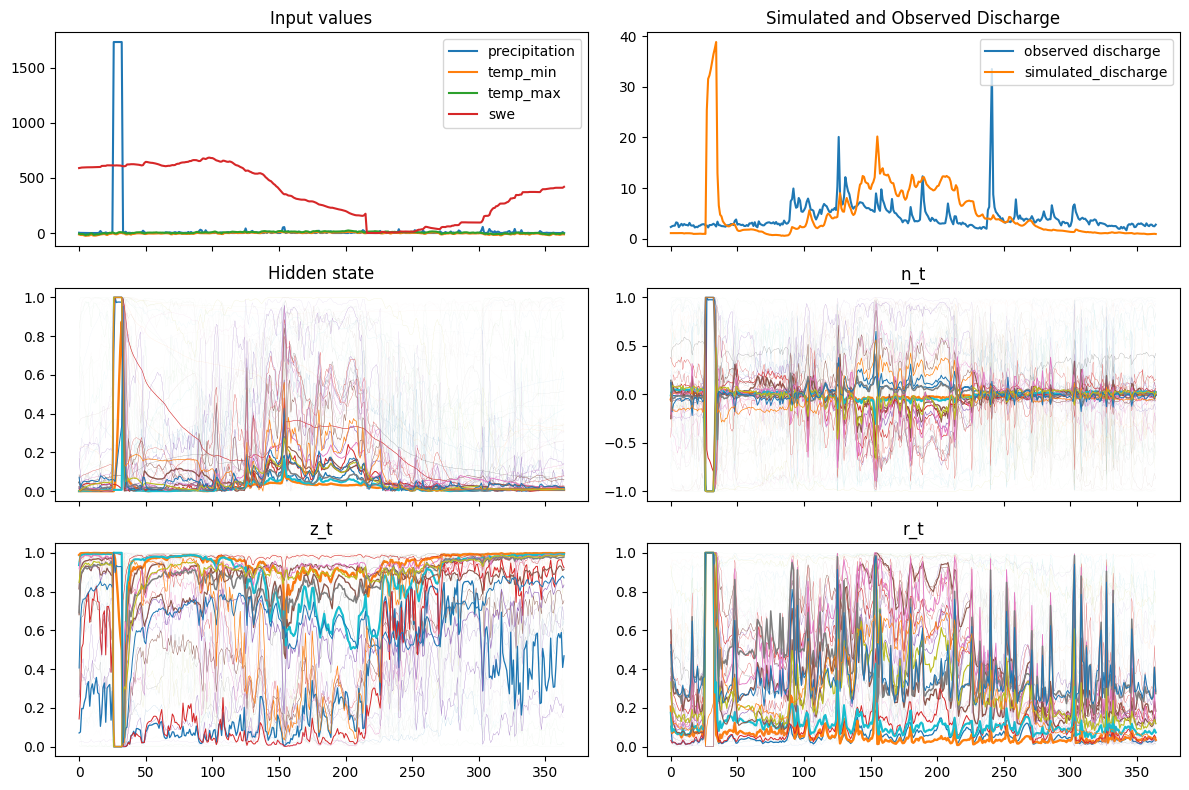

In [72]:
inspectmodel_states = inspect_results_states[basin_to_analyze]
weights_linear, _ = lstm_model.linear.state_dict().items()

f, ax = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
idx = 850
sl = model_hyper_parameters["seq_length"]

# observed input feature values
ax[0,0].set_title('Input values')
x_d_ = testing_dataset[basin_to_analyze].sequence_data[basin_to_analyze]['x_d'][:, 0:5]*dataset.scaler['x_d_std']+dataset.scaler['x_d_mean']
ax[0,0].plot(x_d_[idx:idx+sl, 0], label='precipitation')  
ax[0,0].plot(x_d_[idx:idx+sl, 1], label='temp_min')  
ax[0,0].plot(x_d_[idx:idx+sl, 2], label='temp_max')  
# ax[0,0].plot(x_d_[idx:idx+sl, 3], label='sun_dur')  
ax[0,0].plot(x_d_[idx:idx+sl, 4], label='swe')  
ax[0,0].legend()

ax[0,1].set_title('Simulated and Observed Discharge')
y_obs = dataset.sequence_data[entity]['y_obs'][:]
ax[0,1].plot(y_obs[idx:idx+sl], label='observed discharge', color=color_palette["observed"])
ax[0,1].plot(inspectmodel_states[0]['y_hat'][idx-sl:idx, :].numpy(), label='simulated_discharge', color=color_palette["simulated"])
ax[0,1].legend()

ax[1,0].set_title('Hidden state')
for l in range(inspectmodel_states[0]['h_n'].shape[2]):
    ax[1,0].plot(abs(inspectmodel_states[0]['h_n'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[1,1].set_title('n_t')
for l in range(inspectmodel_states[0]['n_t_'].shape[2]):
    ax[1,1].plot((np.tanh(inspectmodel_states[0]['n_t_'][idx, :, l].numpy())), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[2,0].set_title('z_t')
for l in range(inspectmodel_states[0]['z_t_'].shape[2]):
    ax[2,0].plot(torch.sigmoid(inspectmodel_states[0]['z_t_'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))
# ax[2,1].set_xlim([22, 35])

ax[2,1].set_title('r_t')
for l in range(inspectmodel_states[0]['r_t_'].shape[2]):
    ax[2,1].plot(torch.sigmoid(inspectmodel_states[0]['r_t_'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))
# ax[2,1].set_ylim([-10, 10])

plt.tight_layout()

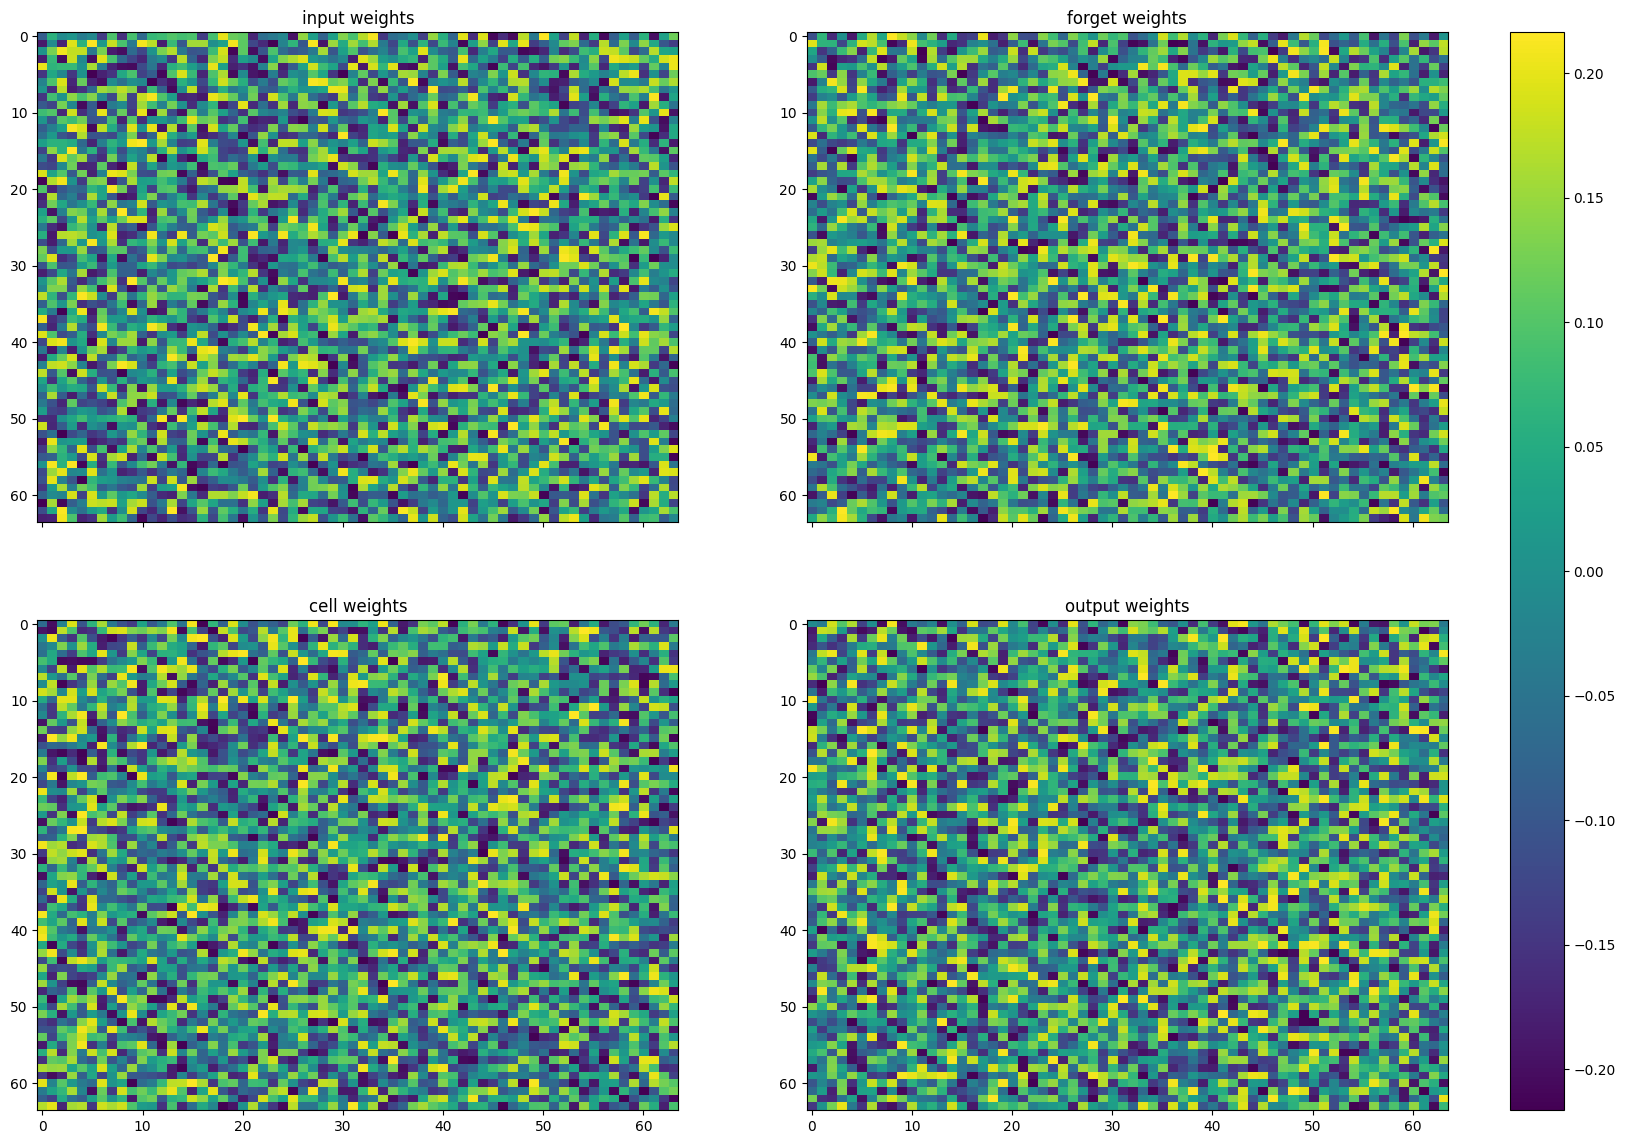

('weight', tensor([[-0.0060,  0.0029,  0.0378,  0.0003, -0.0036,  0.0006, -0.0010,  0.0002,
          0.0021, -0.0029, -0.0011,  0.0025,  0.0001,  0.0029, -0.0008,  0.0024,
         -0.0026, -0.0001,  0.0001, -0.0005,  0.0010, -0.0017,  0.0009,  0.0012,
         -0.0004, -0.0032,  0.0005, -0.0073, -0.0034,  0.0008, -0.0002, -0.0074,
         -0.0063, -0.0006,  0.0008,  0.0043,  0.0006,  0.0007,  0.0012, -0.0008,
         -0.0109, -0.0014, -0.0018, -0.0005,  0.0001,  0.0128,  0.0004, -0.0032,
         -0.0105,  0.0086,  0.0006, -0.0057, -0.0025,  0.0023,  0.0014,  0.0013,
         -0.0013,  0.0020,  0.0052, -0.0035, -0.0111,  0.0021,  0.0011,  0.0022]],
       device='cuda:0'))


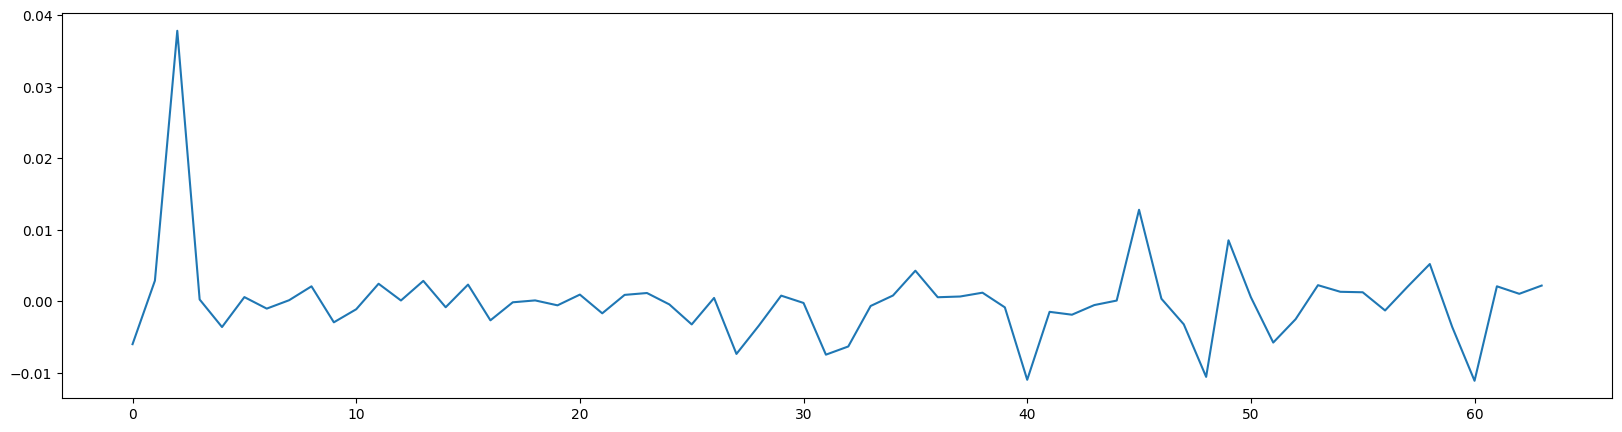

In [40]:
n_hs = model_hyper_parameters["hidden_size"]
w_ii, w_if, w_ig, w_io = torch.split(lstm_model_inspect.cell.w_hh, lstm_model_inspect.cell.w_ih.size(0) // 4, dim=0)

f, ax = plt.subplots(2, 2, figsize=(20, 14), sharex=True)

ax[0,0].set_title('input weights')
hm1 = ax[0,0].imshow(w_ii.detach().cpu().numpy(), aspect='auto')
ax[0,1].set_title('forget weights')
hm2 = ax[0,1].imshow(w_if.detach().cpu().numpy(), aspect='auto')
ax[1,0].set_title('cell weights')
hm3 = ax[1,0].imshow(w_ig.detach().cpu().numpy(), aspect='auto')
ax[1,1].set_title('output weights')
hm4 = ax[1,1].imshow(w_io.detach().cpu().numpy(), aspect='auto')

cbar = f.colorbar(hm1, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

plt.show()

print(weights_linear)
plt.plot(weights_linear[1][0].detach().cpu().numpy())
plt.show()

In [44]:
for weight in lstm_model.cell.parameters():
    print(weight.shape)

torch.Size([256, 64])
torch.Size([256, 27])
torch.Size([256])
torch.Size([256])
